## **Training Notebook for the Distortion Classification Model**
### **Dataset**: OP1_New (85-10-5)
#### **Image Size**: 256*256
##### **Execution environment**: GPU


In [ ]:
!nvidia-smi

Sun Jan  3 18:47:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [ ]:
%tensorflow_version 2.x
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, GlobalMaxPooling2D, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
from glob import glob

In [ ]:
zip_path = '/content/drive/MyDrive/USP/Tesis/Dataset/OP1_New.zip'
!cp '{zip_path}' .
!unzip -q OP1_New.zip
!rm OP1_New.zip

In [ ]:
# image_size = (128,128)

train_path = '/content/OP1/train'
dev_path = '/content/OP1/dev'

train_gen = ImageDataGenerator(rescale=1./255)
dev_gen = ImageDataGenerator(rescale=1./255)

train_set = train_gen.flow_from_directory(
    train_path,
    batch_size=64,
    shuffle = True)

dev_set = dev_gen.flow_from_directory(
    dev_path,
    batch_size=64,
    shuffle = True)

Found 76260 images belonging to 15 classes.
Found 8970 images belonging to 15 classes.


In [ ]:
print(train_set.image_shape)

(256, 256, 3)


In [ ]:
## Define the Model
filter_size = (3,3)
padd = 'valid'
act = 'relu'
# input_size = (256,256,3)

model = Sequential()
model.add(Conv2D(16,
                 kernel_size=filter_size,
                 padding=padd,
                 activation=act,
                 input_shape=train_set.image_shape,
                 name = 'CONV1'))

model.add(MaxPool2D(name = 'MAXPOOL1'))

# model.add(Dropout(0.1, name = 'DROPOUT1'))

model.add(Conv2D(32,
                 kernel_size=filter_size,
                 padding=padd,
                 activation=act,
                 input_shape=train_set.image_shape,
                 name = 'CONV2'))

model.add(MaxPool2D(name = 'MAXPOOL2'))

# model.add(Dropout(0.1, name = 'DROPOUT2'))

model.add(Conv2D(64,
                 kernel_size=filter_size,
                 padding=padd,
                 activation=act,
                 input_shape=train_set.image_shape,
                 name = 'CONV3'))

model.add(MaxPool2D(name = 'MAXPOOL3'))

# model.add(Dropout(0.1, name = 'DROPOUT3'))

model.add(Conv2D(128,
                 kernel_size=filter_size,
                 padding=padd,
                 activation=act,
                 input_shape=train_set.image_shape,
                 name = 'CONV4'))

model.add(MaxPool2D(name = 'MAXPOOL4'))

# model.add(Dropout(0.1, name = 'DROPOUT4'))

model.add(Conv2D(256,
                 kernel_size=filter_size,
                 padding=padd,
                 activation=act,
                 input_shape=train_set.image_shape,
                 name = 'CONV5'))

model.add(GlobalMaxPooling2D(name = 'GLOBAL_MAXPOOL'))

model.add(Dropout(0.2, name = 'DROPOUT4'))

model.add(Dense(units=512,
                activation='relu',
                name ='FC1'))

model.add(Dropout(0.2, name = 'DROPOUT5'))

model.add(Dense(units = 15,
                activation='softmax',
                name = 'OUTPUT'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 254, 254, 16)      448       
_________________________________________________________________
MAXPOOL1 (MaxPooling2D)      (None, 127, 127, 16)      0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 125, 125, 32)      4640      
_________________________________________________________________
MAXPOOL2 (MaxPooling2D)      (None, 62, 62, 32)        0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 60, 60, 64)        18496     
_________________________________________________________________
MAXPOOL3 (MaxPooling2D)      (None, 30, 30, 64)        0         
_________________________________________________________________
CONV4 (Conv2D)               (None, 28, 28, 128)      

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00055, beta_1=0.9,beta_2=0.999)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
!pip install livelossplot
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot.inputs.tf_keras import PlotLossesCallback

In [ ]:
%%time

chkpt = ModelCheckpoint("CNN2_3_OP1New.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min', baseline=None, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [PlotLossesCallback(), chkpt, early_stopping, lr_scheduler]

CPU times: user 378 µs, sys: 0 ns, total: 378 µs
Wall time: 382 µs


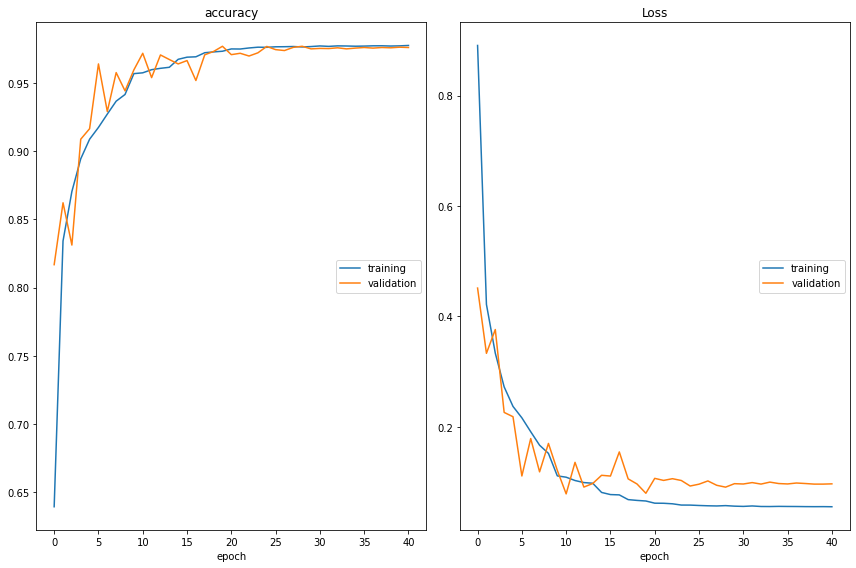

accuracy
	training         	 (min:    0.639, max:    0.978, cur:    0.978)
	validation       	 (min:    0.817, max:    0.977, cur:    0.976)
Loss
	training         	 (min:    0.055, max:    0.891, cur:    0.055)
	validation       	 (min:    0.078, max:    0.451, cur:    0.097)

Epoch 00041: val_loss did not improve from 0.07837

Epoch 00041: ReduceLROnPlateau reducing learning rate to 2.685546860448085e-07.


In [ ]:
history = model.fit(train_set,
          epochs=100,
          validation_data=dev_set,
          callbacks = callbacks,
          shuffle = True,
          verbose=1)

In [ ]:
model.save('model_256')